In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import nltk
import string
import seaborn
import re
import string as sns  # Tutorial about Python regular expressions: https://pymotw.com/2/re/
import pickle
import os

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint as sp_randint
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from collections import Counter 
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import MultinomialNB
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter 
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from tqdm import tqdm



#  Reading Data

In [94]:
dt_ar = pd.read_csv('Reviews.csv', nrows= 100000)
dt_ar.shape

(100000, 10)

In [95]:
def partition (x):
    if x < 3:
        return 0
    return 1

actualScore = dt_ar['Score']
positivenegative = actualScore.map(partition)
dt_ar['Score'] = positivenegative

In [96]:
#Sorting data according to ProductId in ascending order
sorted_data=dt_ar.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [97]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(88463, 10)

In [98]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(dt_ar['Id'].size*1.0)*100

88.46300000000001

In [99]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [100]:
print(final.shape)
final['Score'].value_counts()

(88461, 10)


1    75313
0    13148
Name: Score, dtype: int64

# Featurization

In [101]:
x = dt_ar['Text'].values
y= dt_ar['Score'].values

##  BAG OF WORDS

In [102]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33) 
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) 
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)

vectorizer = CountVectorizer(ngram_range=(1,2), stop_words='english')
vectorize = vectorizer.fit(X_train) 
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100)


(44890,) (44890,)
(22110,) (22110,)
(33000,) (33000,)
After vectorizations
(44890, 807631) (44890,)
(22110, 807631) (22110,)
(33000, 807631) (33000,)


<h2> Applying Decision Tree </h2>

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import tree
clf = tree.DecisionTreeClassifier(class_weight='balanced')
clf = clf.fit(X_train_bow, y_train)
clf.predict_proba(X_train_bow)

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]])

## Hyper Parameter

In [14]:
##https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/6%20Amazon%20Food%20Reviews%20-%20Decision%20Trees.ipynb
clf = DecisionTreeClassifier(class_weight='balanced')
param_grid =  {'max_depth':[1, 5, 10, 50, 100, 500, 1000], 'min_samples_split': [5, 10, 100, 500]}   
gsv = GridSearchCV(clf,param_grid,verbose=1,scoring='roc_auc')
gsv.fit(X_train_bow,y_train)
print("Best HyperParameter: ",gsv.best_params_)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed: 125.1min finished


Best HyperParameter:  {'max_depth': 50, 'min_samples_split': 500}


# Representation Of Results

In [15]:
# take code from samples of code.
import seaborn as sns
def DT_Classifier(X_train,X_cv,y_train,y_cv):
    pred_cv = []
    pred_train = []
    depth = [1, 5, 10, 50, 100, 500, 1000]
    samples_split = [5, 10, 100, 500] 
    for i in depth:
        for j in samples_split:
            clf = DecisionTreeClassifier(max_depth = i, min_samples_split = j)
            clf.fit(X_train_bow,y_train)
            probs = clf.predict_proba(X_cv_bow)
            prob = clf.predict_proba(X_train_bow)
            probs = probs[:,1]
            prob = prob[:,1]
            auc_score_cv = roc_auc_score(y_cv,probs)
            auc_score_train = roc_auc_score(y_train,prob)
            pred_cv.append(auc_score_cv)
            pred_train.append(auc_score_train)
    
    print("-"*30, "Train data", "-"*30)
    pred_train = np.array(pred_train)
    pred_train = pred_train.reshape(len(depth),len(samples_split))
    plt.figure(figsize=(10,5))
    sns.heatmap(pred_train,annot=True, fmt=".3f", xticklabels=samples_split,yticklabels=depth)
    plt.xlabel('Min_Sample_Split')
    plt.ylabel('Max_Depth')
    plt.show()
    print("-"*30, "CV data", "-"*30)
    pred_cv = np.array(pred_cv)
    pred_cv = pred_cv.reshape(len(depth),len(samples_split))
    plt.figure(figsize=(10,5))
    sns.heatmap(pred_cv, annot=True, fmt=".3f", xticklabels=samples_split, yticklabels=depth)
    plt.xlabel('Min_Sample_Split')
    plt.ylabel('Max_Depth')
    plt.show()

------------------------------ Train data ------------------------------


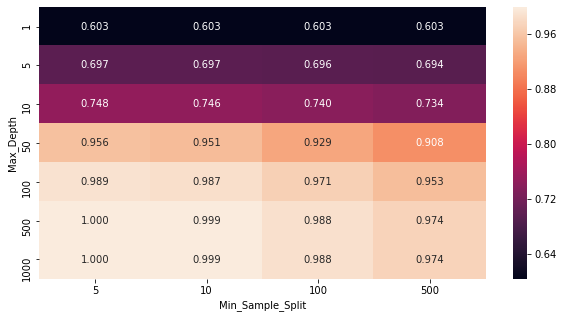

------------------------------ CV data ------------------------------


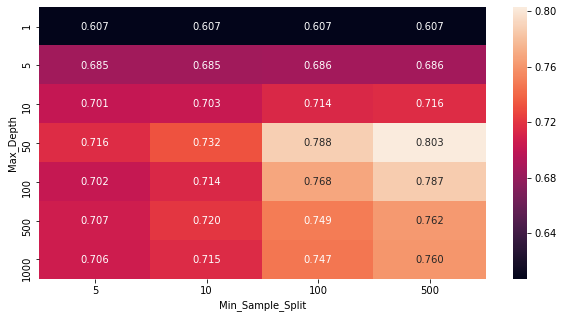

In [16]:
from sklearn.metrics import roc_auc_score
DT_Classifier(X_train_bow,X_cv_bow,y_train,y_cv)

<h2> Confusion Matrix  </h2>

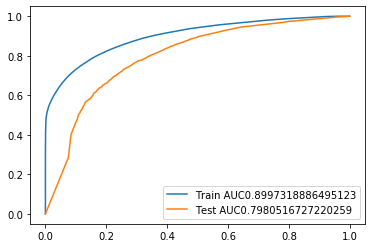

============================== train ==============================


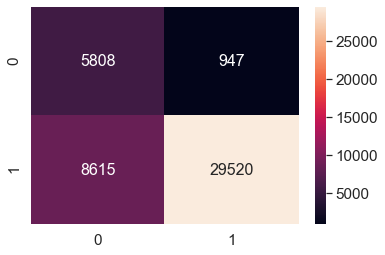

============================== test ==============================


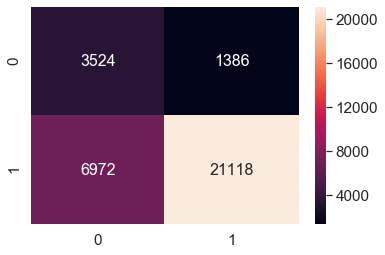

In [22]:
import seaborn as sns
from sklearn.metrics import roc_curve
clf = DecisionTreeClassifier(class_weight='balanced', max_depth=50,min_samples_split=500)
clf.fit(X_train_bow,y_train)
y_pred = clf.predict(X_train_bow)
y_test_pred = clf.predict(X_test_bow)

y_test_pred_proba = clf.predict_proba(X_test_bow)[:, 1]
y_train_pred_proba = clf.predict_proba(X_train_bow)[:, 1]


train_fpr, train_tpr, thr_train = roc_curve(y_train, y_train_pred_proba)
test_fpr, test_tpr, thr_test = roc_curve(y_test, y_test_pred_proba)

plt.plot(train_fpr, train_tpr,label="Train AUC"+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr,  label="Test AUC"+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.show()

print("="*30, "train", "="*30)
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.show()

print("="*30, "test", "="*30)
cm = pd.DataFrame(confusion_matrix(y_test, y_test_pred), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.show()

# Top Feature Importance

In [104]:
from sklearn.tree import tree
clf = tree.DecisionTreeClassifier(class_weight='balanced', max_depth=50,min_samples_split=500)
clf.fit(X_train_bow, y_train)
importances = clf.feature_importances_
indices = np.argsort(importances)

pos_class_prob_sorted = clf.feature_importances_[1 ::].argsort()
neg_class_prob_sorted = clf.feature_importances_[0 ::].argsort()
print("Top 20 positive class Features Importance")
print(np.take(vectorizer.get_feature_names(), pos_class_prob_sorted[10:30]))
print("Top 20 negative class Features Importance")
print(np.take(vectorizer.get_feature_names(), neg_class_prob_sorted[10:30]))

Top 20 positive class Features Importance
['pop short' 'pop started' 'pop stay' 'pop stir' 'pop store' 'pop stores'
 'pop stove' 'pop stovetop' 'pop straw' 'pop suffer' 'pop sugar'
 'pop state' 'pop seven' 'pop senior' 'pop send' 'pop potatoes' 'pop pour'
 'pop pre' 'pop pretty' 'pop probably']
Top 20 negative class Features Importance
['pop sides' 'pop state' 'pop stir' 'pop store' 'pop stores' 'pop stove'
 'pop stovetop' 'pop straw' 'pop suffer' 'pop sugar' 'pop super'
 'pop stay' 'pop short' 'pop seven' 'pop senior' 'pop pour' 'pop pre'
 'pop pretty' 'pop probably' 'pop pun']


# TF_IDF

In [103]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
vectorizer_1 =  TfidfVectorizer(ngram_range=(1,2), stop_words='english')
vectorizer_1.fit(X_train) 

X_train_tfidf = vectorizer_1.transform(X_train)
X_cv_tfidf = vectorizer_1.transform(X_cv)
X_test_tfidf = vectorizer_1.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)
print("="*100)

After vectorizations
(44890, 807631) (44890,)
(22110, 807631) (22110,)
(33000, 807631) (33000,)


# Applying DecesionTree

In [18]:
clf = tree.DecisionTreeClassifier(class_weight='balanced')
clf = clf.fit(X_train_tfidf, y_train)
clf.predict_proba(X_train_tfidf)

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]])

# Best  HyperParameter 

In [19]:
##https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/6%20Amazon%20Food%20Reviews%20-%20Decision%20Trees.ipynb
clf = DecisionTreeClassifier(class_weight='balanced')
param_grid =  {'max_depth':[1, 5, 10, 50, 100, 500, 1000], 'min_samples_split': [5, 10, 100, 500]}   
gsv = GridSearchCV(clf,param_grid,verbose=1,scoring='roc_auc')
gsv.fit(X_train_tfidf,y_train)
print("Best HyperParameter: ",gsv.best_params_)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed: 27.5min finished


Best HyperParameter:  {'max_depth': 50, 'min_samples_split': 500}


# Representation Of  Results

In [20]:
import seaborn as sns
def DT_Classifier(X_train,X_cv,y_train,y_cv):
    pred_cv = []
    pred_train = []
    depth = [1, 5, 10, 50, 100, 500, 1000]
    samples_split = [5, 10, 100, 500] 
    for i in depth:
        for j in samples_split:
            clf = DecisionTreeClassifier(max_depth = i, min_samples_split = j)
            clf.fit(X_train_tfidf,y_train)
            probs = clf.predict_proba(X_cv_tfidf)
            prob = clf.predict_proba(X_train_tfidf)
            probs = probs[:,1]
            prob = prob[:,1]
            auc_score_cv = roc_auc_score(y_cv,probs)
            auc_score_train = roc_auc_score(y_train,prob)
            pred_cv.append(auc_score_cv)
            pred_train.append(auc_score_train)
    
    print("-"*30, "Train data", "-"*30)
    pred_train = np.array(pred_train)
    pred_train = pred_train.reshape(len(depth),len(samples_split))
    plt.figure(figsize=(10,5))
    sns.heatmap(pred_train,annot=True, fmt=".3f", xticklabels=samples_split,yticklabels=depth)
    plt.xlabel('Min_Sample_Split')
    plt.ylabel('Max_Depth')
    plt.show()
    print("-"*30, "CV data", "-"*30)
    pred_cv = np.array(pred_cv)
    pred_cv = pred_cv.reshape(len(depth),len(samples_split))
    plt.figure(figsize=(10,5))
    sns.heatmap(pred_cv, annot=True, fmt=".3f", xticklabels=samples_split, yticklabels=depth)
    plt.xlabel('Min_Sample_Split')
    plt.ylabel('Max_Depth')
    plt.show()

------------------------------ Train data ------------------------------


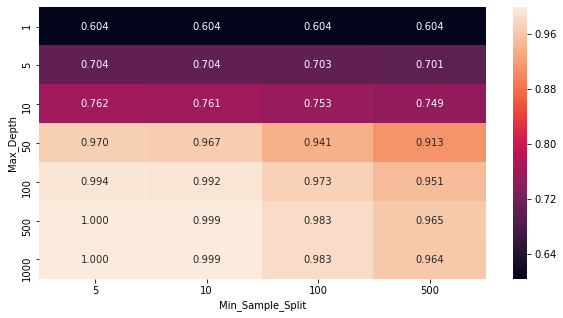

------------------------------ CV data ------------------------------


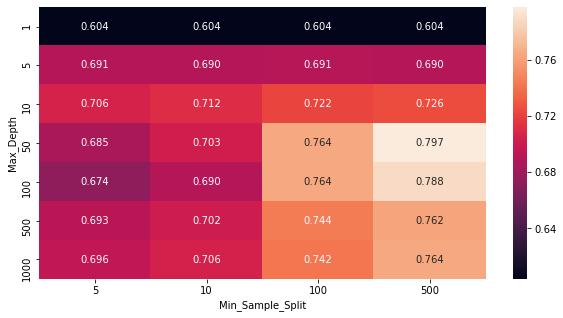

In [21]:
from sklearn.metrics import roc_auc_score
DT_Classifier(X_train_tfidf,X_cv_tfidf,y_train,y_cv)

# Confusion Matrix

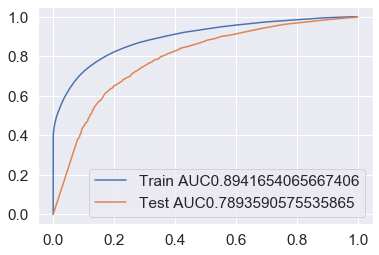

============================== train ==============================


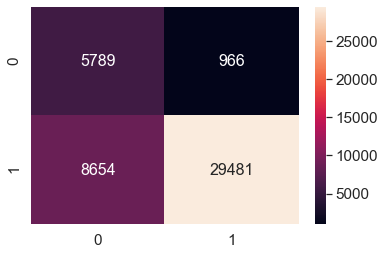

============================== test ==============================


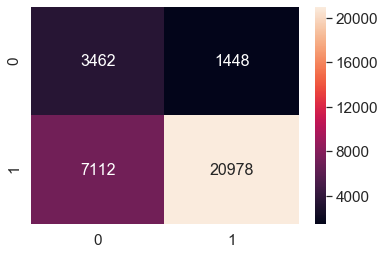

In [23]:
import seaborn as sns
from sklearn.metrics import roc_curve
clf = DecisionTreeClassifier(class_weight='balanced', max_depth=50,min_samples_split=500)
clf.fit(X_train_tfidf,y_train)
y_pred = clf.predict(X_train_tfidf)
y_test_pred = clf.predict(X_test_tfidf)

y_test_pred_proba = clf.predict_proba(X_test_tfidf)[:, 1]
y_train_pred_proba = clf.predict_proba(X_train_tfidf)[:, 1]


train_fpr, train_tpr, thr_train = roc_curve(y_train, y_train_pred_proba)
test_fpr, test_tpr, thr_test = roc_curve(y_test, y_test_pred_proba)

plt.plot(train_fpr, train_tpr,label="Train AUC"+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr,  label="Test AUC"+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.show()

print("="*30, "train", "="*30)
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.show()

print("="*30, "test", "="*30)
cm = pd.DataFrame(confusion_matrix(y_test, y_test_pred), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.show()

# Feature Importance 

In [105]:
from sklearn.tree import tree
clf = tree.DecisionTreeClassifier(class_weight='balanced', max_depth=50,min_samples_split=500)
clf.fit(X_train_tfidf, y_train)
importances = clf.feature_importances_
indices = np.argsort(importances)

pos_class_prob_sorted = clf.feature_importances_[1 ::].argsort()
neg_class_prob_sorted = clf.feature_importances_[0 ::].argsort()
print("Top 20 positive class Features Importance")
print(np.take(vectorizer.get_feature_names(), pos_class_prob_sorted[10:30]))
print("Top 20 negative class Features Importance")
print(np.take(vectorizer.get_feature_names(), neg_class_prob_sorted[10:30]))

Top 20 positive class Features Importance
['pop potatoes' 'pop really' 'pop refreshing' 'pop rice' 'pop right'
 'pop rock' 'pop rocks' 'pop satisfied' 'pop saucepan' 'pop screw'
 'pop secret' 'pop recommended' 'pop portions' 'pop portion' 'pop pops'
 'pop open' 'pop opening' 'pop operation' 'pop ounces' 'pop oven']
Top 20 negative class Features Importance
['pop pour' 'pop recommended' 'pop rice' 'pop right' 'pop rock'
 'pop rocks' 'pop satisfied' 'pop saucepan' 'pop screw' 'pop secret'
 'pop send' 'pop refreshing' 'pop potatoes' 'pop portions' 'pop portion'
 'pop opening' 'pop operation' 'pop ounces' 'pop oven' 'pop pack']


# Word2Vec

In [106]:
nltk.download('stopwords')

stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')


def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/|]',r' ',cleaned)
    return cleaned

print(stop)
print('******************************************')
print(sno.stem('tasty'))


{'wouldn', 'when', 'should', 'in', 'about', 'they', 'ours', 'me', 'for', "doesn't", 'then', 'some', "don't", 'them', 'where', 've', 'd', 'mightn', 'under', 'because', 'themselves', 'above', 'yourselves', 'both', 'between', 'hers', 'any', 'those', "should've", "hasn't", "haven't", 'ma', 'needn', "she's", 'couldn', 'this', 'been', 'being', 'her', 'shan', 'once', 'how', 'we', 'herself', 'who', 'am', 'out', 'hasn', "you'll", 'over', 'be', 'm', 'aren', 'more', "weren't", 'will', 'their', 'by', 'was', 'ourselves', "needn't", 'did', 'these', 'as', 'up', 're', 'down', 'no', "hadn't", 'doesn', 'have', "isn't", 'to', 'having', 'myself', 'if', 'do', 'all', 'until', 'nor', 'few', 'other', 'there', "aren't", 'now', "shouldn't", "couldn't", 'and', 'only', 'he', 'll', 'such', "mightn't", 'himself', 'you', 'hadn', 'into', 'most', 'him', 'own', 'very', 'has', 'through', 'whom', 'off', 's', 'can', 'his', 'each', 'yourself', 'too', 'wasn', 'yours', 'after', 'does', 'at', 'than', 'against', 'shouldn', "yo

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [107]:
i=0
str1=''
final_string=[]
all_positive_words=[]
all_negative_words=[]
s=''
for sent in dt_ar['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (dt_ar['Score'].values)[i] == 'positive':
                        all_positive_words.append(s)
                    if (dt_ar['Score'].values)[i] == 'negative':
                        all_negative_words.append(s)
                    else:
                        continue
                else:
                    continue
    str1 = b" ".join(filtered_sentence)
   # print("***********************************************************************888")
    final_string.append(str1)
    i+=1

In [108]:
dt_ar['CleanedText']=final_string

In [109]:
i=0
list_of_sent=[]
for sent in dt_ar['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sent.append(filtered_sentence) 

In [110]:
print(dt_ar['Text'].values[0])
print("***********************************************************************************")
print(list_of_sent[0])

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
***********************************************************************************
['i', 'have', 'bought', 'several', 'of', 'the', 'vitality', 'canned', 'dog', 'food', 'products', 'and', 'have', 'found', 'them', 'all', 'to', 'be', 'of', 'good', 'quality', 'the', 'product', 'looks', 'more', 'like', 'a', 'stew', 'than', 'a', 'processed', 'meat', 'and', 'it', 'smells', 'better', 'my', 'labrador', 'is', 'finicky', 'and', 'she', 'appreciates', 'this', 'product', 'better', 'than', 'most']


# Train Data

In [111]:
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

In [112]:
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)

In [113]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  25775
sample words  ['I', 'have', 'several', 'types', 'of', 'baby', 'food', 'molds', 'and', 'this', 'is', 'my', 'favorite.', 'It', 'soft', 'rubbery', 'so', 'am', 'able', 'to', 'push', 'up', 'from', 'the', 'bottom', 'mold', 'remove', 'food.', "don't", 'like', 'having', 'run', 'hot', 'water', 'over', 'back,', 'with', 'other', 'because', 'tap', 'getting', 'on', "(I'm", 'a', 'little', 'Just', 'make', 'sure', 'not', 'fill']


In [114]:
sent_vectors_train = [];
for sent in tqdm(list_of_sentance_train): 
    sent_vec = np.zeros(50)
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|████████████████████████████████████████████████████████████████████████████| 44890/44890 [08:27<00:00, 88.53it/s]


(44890, 50)
[ 0.21636549 -1.49375891  0.73785244 -0.48257093  0.1733796   0.48385841
 -0.94177184 -0.13185396 -1.0294288   0.52672563  0.3934677  -1.0129168
 -0.84031682  0.35132419 -0.10816079 -0.66665789 -0.26866142 -0.37855159
 -0.70595463 -0.81506381 -0.7238638   0.53388723  0.01620667 -0.63052346
  1.35907859  0.17096474  0.42114232 -0.50088192 -0.16921174 -0.57515126
 -0.40981117  0.30904729  1.42323882  0.41172036 -0.05884418 -0.02716337
  0.67673927 -0.19406475 -0.15728977  0.24447561 -0.3278684  -0.49398404
 -0.28440367  0.60968627  0.17268872 -0.30448976 -0.68810047  0.20790328
  0.20506331  0.10427168]


# Cross_Validation Data

In [115]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [116]:

list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
sent_vectors_cv = []; 
for sent in tqdm(list_of_sentance_cv): 
    sent_vec = np.zeros(50)
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|████████████████████████████████████████████████████████████████████████████| 22110/22110 [04:17<00:00, 85.94it/s]


(22110, 50)
[ 0.10991243 -0.40366495  0.46731069 -0.90419714  0.10877982  0.36558871
 -0.68629705 -0.52271245 -0.16129595  0.39541406  0.26823648 -0.91071801
 -0.15140454  0.1353359  -0.09958943 -0.51533595  0.54570832 -0.50706233
 -0.24162173 -0.38785456 -0.53219623  0.45900658  0.03940231 -0.25789046
  1.32824032 -0.00669816  0.58209723  0.30301183 -0.24929727 -0.51972071
 -0.76160133  0.08635199  0.84545517  0.03216962  0.06374707  0.21754567
  0.73931234  0.11441517 -0.0353628   0.36741626 -0.47436879 -0.39200821
 -0.17242385  0.36177962 -0.18474543 -0.61305184 -0.43277954  0.24884713
  0.08696545  0.95215404]


# Test Data

In [117]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [118]:
sent_vectors_test = [];
for sent in tqdm(list_of_sentance_test): 
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|████████████████████████████████████████████████████████████████████████████| 33000/33000 [07:12<00:00, 76.28it/s]


(33000, 50)
[ 0.47943362 -0.63922265  0.35146106 -0.98772044 -0.03360602  0.11511482
 -0.98904466 -0.47622584 -1.48604794  0.92021738  0.41612809 -0.88775787
 -1.25573192  0.2706762   0.33196056 -0.44147191  0.17196487 -0.51917682
 -0.62640251 -1.18423059 -1.00437065  1.06413257  0.3549627  -0.16658515
  1.38929429  0.83247827  0.76029227  0.0447554   0.21004496 -0.53954306
 -1.0803561  -0.18193011  1.65718379 -0.39894767 -0.28431533  0.20152355
  0.09702093 -0.0553039  -0.55978583 -0.51954701 -1.09504514  0.15205906
  0.04830835  0.74777688 -0.07075133 -0.20634483 -0.3096303   0.36963014
 -0.32216257  0.29321139]


# Applying DecesionTree

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import tree
clf = tree.DecisionTreeClassifier(class_weight='balanced')
clf = clf.fit(sent_vectors_train, y_train)
clf.predict_proba(sent_vectors_train)

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]])

# Best HyperParameter

In [38]:
##https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/6%20Amazon%20Food%20Reviews%20-%20Decision%20Trees.ipynb
clf = DecisionTreeClassifier(class_weight='balanced')
param_grid =  {'max_depth':[1, 5, 10, 50, 100, 500, 1000], 'min_samples_split': [5, 10, 100, 500]}   
gsv = GridSearchCV(clf,param_grid,verbose=1,scoring='roc_auc')
gsv.fit(sent_vectors_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:  3.9min finished


Best HyperParameter:  {'max_depth': 10, 'min_samples_split': 500}


# Representation Of  Results

In [39]:
import seaborn as sns
def DT_Classifier(X_train,X_cv,y_train,y_cv):
    pred_cv = []
    pred_train = []
    depth = [1, 5, 10, 50, 100, 500, 1000]
    samples_split = [5, 10, 100, 500] 
    for i in depth:
        for j in samples_split:
            clf = DecisionTreeClassifier(max_depth = i, min_samples_split = j)
            clf.fit(sent_vectors_train,y_train)
            probs = clf.predict_proba(sent_vectors_cv)
            prob = clf.predict_proba(sent_vectors_train)
            probs = probs[:,1]
            prob = prob[:,1]
            auc_score_cv = roc_auc_score(y_cv,probs)
            auc_score_train = roc_auc_score(y_train,prob)
            pred_cv.append(auc_score_cv)
            pred_train.append(auc_score_train)
    
    print("-"*30, "Train data", "-"*30)
    pred_train = np.array(pred_train)
    pred_train = pred_train.reshape(len(depth),len(samples_split))
    plt.figure(figsize=(10,5))
    sns.heatmap(pred_train,annot=True, fmt=".3f", xticklabels=samples_split,yticklabels=depth)
    plt.xlabel('Min_Sample_Split')
    plt.ylabel('Max_Depth')
    plt.show()
    print("-"*30, "CV data", "-"*30)
    pred_cv = np.array(pred_cv)
    pred_cv = pred_cv.reshape(len(depth),len(samples_split))
    plt.figure(figsize=(10,5))
    sns.heatmap(pred_cv, annot=True, fmt=".3f", xticklabels=samples_split, yticklabels=depth)
    plt.xlabel('Min_Sample_Split')
    plt.ylabel('Max_Depth')
    plt.show()

------------------------------ Train data ------------------------------


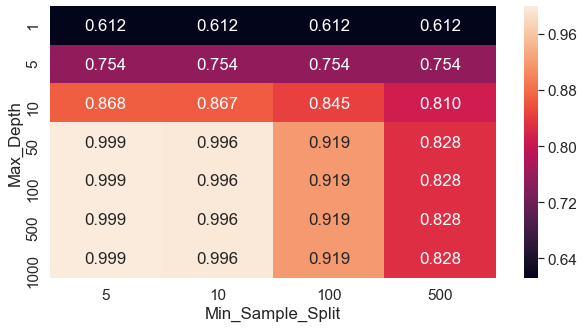

------------------------------ CV data ------------------------------


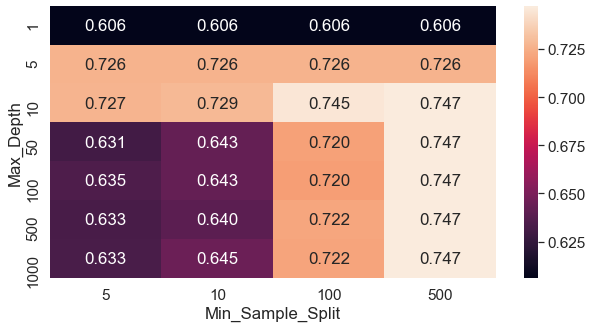

In [40]:
from sklearn.metrics import roc_auc_score
DT_Classifier(sent_vectors_train,sent_vectors_cv,y_train,y_cv)

# Confusion Matrix

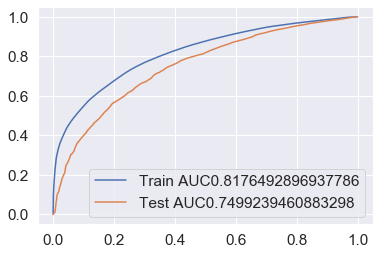

============================== train ==============================


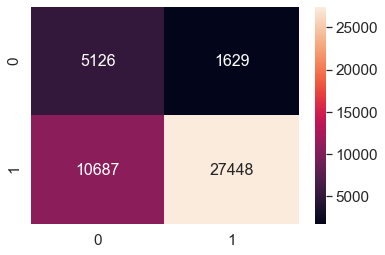

============================== test ==============================


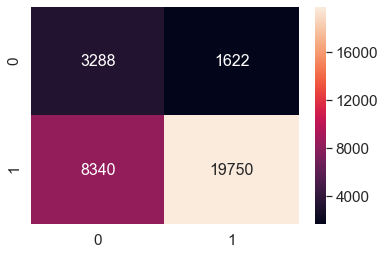

In [48]:
import seaborn as sns
from sklearn.metrics import roc_curve
clf = DecisionTreeClassifier(class_weight='balanced', max_depth=10,min_samples_split=500)
clf.fit(sent_vectors_train,y_train)
y_pred = clf.predict(sent_vectors_train)
y_test_pred = clf.predict(sent_vectors_test)

y_test_pred_proba = clf.predict_proba(sent_vectors_test)[:, 1]
y_train_pred_proba = clf.predict_proba(sent_vectors_train)[:, 1]


train_fpr, train_tpr, thr_train = roc_curve(y_train, y_train_pred_proba)
test_fpr, test_tpr, thr_test = roc_curve(y_test, y_test_pred_proba)

plt.plot(train_fpr, train_tpr,label="Train AUC"+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr,  label="Test AUC"+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.show()

print("="*30, "train", "="*30)
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.show()

print("="*30, "test", "="*30)
cm = pd.DataFrame(confusion_matrix(y_test, y_test_pred), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.show()

# AvgWord2Vec

# Train Data

In [119]:
from tqdm import tqdm 
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(dt_ar['CleanedText'].values)
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
tfidf_feat = model.get_feature_names()
tfidf_sent_vectors_train = [];  
row=0;
for sent in tqdm(list_of_sentance_train):
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))  
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
    
tfidf_sent_vectors_train = np.array(sent_vectors_train)
print(tfidf_sent_vectors_train.shape)
print(tfidf_sent_vectors_train[0])

100%|██████████████████████████████████████████████████████████████████████████| 44890/44890 [1:08:44<00:00, 15.13it/s]


(44890, 50)
[ 0.21636549 -1.49375891  0.73785244 -0.48257093  0.1733796   0.48385841
 -0.94177184 -0.13185396 -1.0294288   0.52672563  0.3934677  -1.0129168
 -0.84031682  0.35132419 -0.10816079 -0.66665789 -0.26866142 -0.37855159
 -0.70595463 -0.81506381 -0.7238638   0.53388723  0.01620667 -0.63052346
  1.35907859  0.17096474  0.42114232 -0.50088192 -0.16921174 -0.57515126
 -0.40981117  0.30904729  1.42323882  0.41172036 -0.05884418 -0.02716337
  0.67673927 -0.19406475 -0.15728977  0.24447561 -0.3278684  -0.49398404
 -0.28440367  0.60968627  0.17268872 -0.30448976 -0.68810047  0.20790328
  0.20506331  0.10427168]


# Cross_Validation Data

In [120]:
from tqdm import tqdm 
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(dt_ar['CleanedText'].values)
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
tfidf_sent_vectors_cv = [];
row=0;
for sent in tqdm(list_of_sentance_cv):
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))  
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1
tfidf_sent_vectors_cv = np.array(sent_vectors_cv)
print(tfidf_sent_vectors_cv.shape)
print(tfidf_sent_vectors_cv[0])   

100%|████████████████████████████████████████████████████████████████████████████| 22110/22110 [31:55<00:00, 11.54it/s]


(22110, 50)
[ 0.10991243 -0.40366495  0.46731069 -0.90419714  0.10877982  0.36558871
 -0.68629705 -0.52271245 -0.16129595  0.39541406  0.26823648 -0.91071801
 -0.15140454  0.1353359  -0.09958943 -0.51533595  0.54570832 -0.50706233
 -0.24162173 -0.38785456 -0.53219623  0.45900658  0.03940231 -0.25789046
  1.32824032 -0.00669816  0.58209723  0.30301183 -0.24929727 -0.51972071
 -0.76160133  0.08635199  0.84545517  0.03216962  0.06374707  0.21754567
  0.73931234  0.11441517 -0.0353628   0.36741626 -0.47436879 -0.39200821
 -0.17242385  0.36177962 -0.18474543 -0.61305184 -0.43277954  0.24884713
  0.08696545  0.95215404]


# Test Data

In [121]:
from tqdm import tqdm 
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(dt_ar['CleanedText'].values)
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
tfidf_sent_vectors_test = [];
row=0;
for sent in tqdm(list_of_sentance_test):
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))  
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
tfidf_sent_vectors_test = np.array(tfidf_sent_vectors_test)
print(tfidf_sent_vectors_test.shape)
print(tfidf_sent_vectors_test[0])

100%|████████████████████████████████████████████████████████████████████████████| 33000/33000 [53:46<00:00,  3.43it/s]


(33000, 50)
[ 0.42371513 -0.12988698  0.22371075 -0.50864855  0.42148148 -0.05723529
 -0.64525827 -0.99444154 -1.82580293  0.57147163  0.46880913 -0.93299519
 -2.54026611  0.91861597  0.1999221  -0.20675263  0.36331676  0.35922145
 -0.86229881 -0.89392812 -0.7258014   0.10040237  1.10483651  0.17954724
  2.23228915  0.27806913  1.29972527 -0.99108876  0.75649617 -1.22831526
 -0.68109026  0.06124181  1.65216612  0.19000074 -0.54573021  0.28277785
 -0.91042298 -0.47184573 -0.3057467  -0.50980338 -1.23379125  0.21473013
 -0.25342995  0.7122378   0.14132237 -0.34430992 -1.21727349  0.69340546
  0.31424377  0.5660317 ]


# Applying DecesionTree

In [122]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import tree
clf = tree.DecisionTreeClassifier(class_weight='balanced')
clf = clf.fit(tfidf_sent_vectors_train, y_train)
clf.predict_proba(tfidf_sent_vectors_train)

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

# Best Hyper Parameter

In [123]:
##https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/6%20Amazon%20Food%20Reviews%20-%20Decision%20Trees.ipynb
clf = DecisionTreeClassifier(class_weight='balanced')
param_grid =  {'max_depth':[1, 5, 10, 50, 100, 500, 1000], 'min_samples_split': [5, 10, 100, 500]}   
gsv = GridSearchCV(clf,param_grid,verbose=1,scoring='roc_auc')
gsv.fit(tfidf_sent_vectors_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:  3.2min finished


Best HyperParameter:  {'max_depth': 10, 'min_samples_split': 500}


# Representation  Of Results

In [124]:
import seaborn as sns
def DT_Classifier(X_train,X_cv,y_train,y_cv):
    pred_cv = []
    pred_train = []
    depth = [1, 5, 10, 50, 100, 500, 1000]
    samples_split = [5, 10, 100, 500] 
    for i in depth:
        for j in samples_split:
            clf = DecisionTreeClassifier(max_depth = i, min_samples_split = j)
            clf.fit(tfidf_sent_vectors_train,y_train)
            probs = clf.predict_proba(tfidf_sent_vectors_cv)
            prob = clf.predict_proba(tfidf_sent_vectors_train)
            probs = probs[:,1]
            prob = prob[:,1]
            auc_score_cv = roc_auc_score(y_cv,probs)
            auc_score_train = roc_auc_score(y_train,prob)
            pred_cv.append(auc_score_cv)
            pred_train.append(auc_score_train)
    
    print("-"*30, "Train data", "-"*30)
    pred_train = np.array(pred_train)
    pred_train = pred_train.reshape(len(depth),len(samples_split))
    plt.figure(figsize=(10,5))
    sns.heatmap(pred_train,annot=True, fmt=".3f", xticklabels=samples_split,yticklabels=depth)
    plt.xlabel('Min_Sample_Split')
    plt.ylabel('Max_Depth')
    plt.show()
    print("-"*30, "CV data", "-"*30)
    pred_cv = np.array(pred_cv)
    pred_cv = pred_cv.reshape(len(depth),len(samples_split))
    plt.figure(figsize=(10,5))
    sns.heatmap(pred_cv, annot=True, fmt=".3f", xticklabels=samples_split, yticklabels=depth)
    plt.xlabel('Min_Sample_Split')
    plt.ylabel('Max_Depth')
    plt.show()

------------------------------ Train data ------------------------------


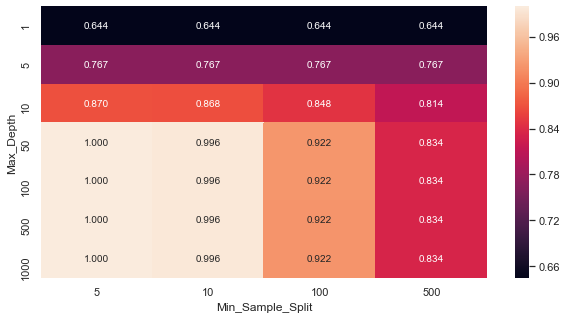

------------------------------ CV data ------------------------------


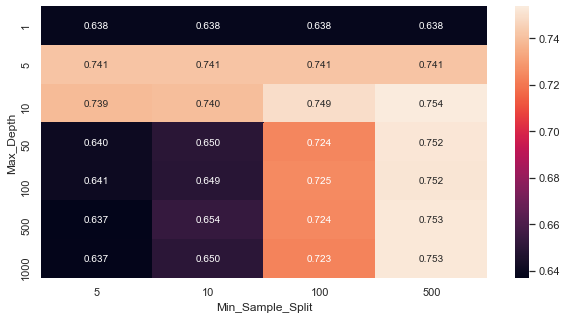

In [125]:
from sklearn.metrics import roc_auc_score
DT_Classifier(tfidf_sent_vectors_train,tfidf_sent_vectors_cv,y_train,y_cv)

# Confuision Matrix

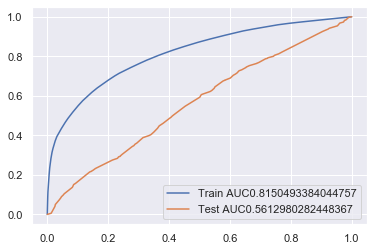

============================== train ==============================


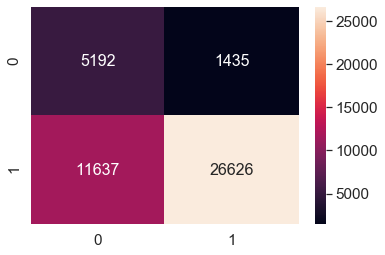

============================== test ==============================


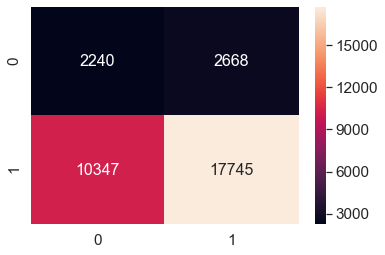

In [126]:
import seaborn as sns
from sklearn.metrics import roc_curve
clf = DecisionTreeClassifier(class_weight='balanced', max_depth=10,min_samples_split=500)
clf.fit(tfidf_sent_vectors_train,y_train)
y_pred = clf.predict(tfidf_sent_vectors_train)
y_test_pred = clf.predict(tfidf_sent_vectors_test)

y_test_pred_proba = clf.predict_proba(tfidf_sent_vectors_test)[:, 1]
y_train_pred_proba = clf.predict_proba(tfidf_sent_vectors_train)[:, 1]


train_fpr, train_tpr, thr_train = roc_curve(y_train, y_train_pred_proba)
test_fpr, test_tpr, thr_test = roc_curve(y_test, y_test_pred_proba)

plt.plot(train_fpr, train_tpr,label="Train AUC"+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr,  label="Test AUC"+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.show()

print("="*30, "train", "="*30)
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.show()

print("="*30, "test", "="*30)
cm = pd.DataFrame(confusion_matrix(y_test, y_test_pred), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.show()

# Conclusion Table

In [127]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model 1", "Hyper Parameter:- 1.Max-DepthMin", "2.simple-split", "Train_AUC", "Test_AUC"]
x.add_row(["BOW", "Desicion Tress", 50, 500, 0.89, 0.79 ])
x.add_row(["TFIDF", "Desicion Tress", 50, 500, 0.89, 0.78])
x.add_row(["W2V", "Desicion Tress", 10, 500, 0.81, 0.74])
x.add_row(["TFIDFW2V", "Desicion Tress", 10, 500, 0.81, 0.56])
print(x)

+------------+----------------+----------------------------------+----------------+-----------+----------+
| Vectorizer |    Model 1     | Hyper Parameter:- 1.Max-DepthMin | 2.simple-split | Train_AUC | Test_AUC |
+------------+----------------+----------------------------------+----------------+-----------+----------+
|    BOW     | Desicion Tress |                50                |      500       |    0.89   |   0.79   |
|   TFIDF    | Desicion Tress |                50                |      500       |    0.89   |   0.78   |
|    W2V     | Desicion Tress |                10                |      500       |    0.81   |   0.74   |
|  TFIDFW2V  | Desicion Tress |                10                |      500       |    0.81   |   0.56   |
+------------+----------------+----------------------------------+----------------+-----------+----------+


# Conclusion:-

1. First loaded Amazon fine food reviews and then did preprocessing in text feature.
2. Then splited data into train data, test data, and cross-validation data and then apply featurization in it.
3. Then featurised datapoint in 4 featurization BOW, TFIDF, Word2Vec, TfidfAvgword2Vec and then apply decision tree in it.
4. Then calculated hyper parameter for max_depth and min_sample_split using gridsearch for BOW, TFIDF, Word2Vec and AvgWord2vec.
5. Then calculated top 20  positive and negative features names for BOW, TFIdf, Word2vec, Avgword2Vec .
6. Then perform of result  and claculated confusion matrix for train data, tes data, and cross-validation for BOW, TFIDF, Word2Vec, AvgWord2Vec.
7. Then did feature engineering for BOW, TFIDF, Word2Vec and AvgWordvec.
8. Then caclculated conclusion table for hyper parameter , train_auc, test_auc.

#  =============================================================